# Optimisation

In [2]:
# Copyright (C) 2020. Huawei Technologies Co., Ltd. All rights reserved.

# This program is free software; you can redistribute it and/or modify it under
# the terms of the MIT license.

# This program is distributed in the hope that it will be useful, but WITHOUT ANY
# WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
# PARTICULAR PURPOSE. See the MIT License for more details.

import sys
sys.path.append('../')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from pymoo.factory import get_problem,get_visualization


from hebo.optimizers.hebo import HEBO
from hebo.optimizers.bo import BO

import warnings
warnings.filterwarnings("ignore")


## Demo problem definition

We will introduce the optimizer API using branin function defined in [pymoo library](https://pymoo.org/problems/index.html)

This is what branin function looks like, it has three local minima

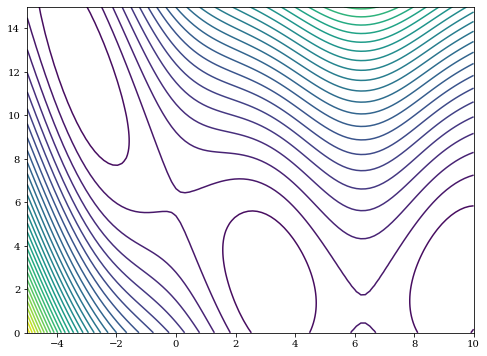

In [2]:
problem = get_problem('go-branin01')

get_visualization("fitness-landscape", problem, angle=(45, 45), _type="contour").show()

## Objective function wrapper

The branin function is wrapped using `obj(x : pd.DataFrame) -> pd.DataFrame`

In [3]:
def obj(x : pd.DataFrame) -> np.ndarray:
    x     = x[['x0','x1']].values
    num_x = x.shape[0]
    ret   = np.zeros((num_x,1))
    for i in range(num_x):
        out = {}
        try:
            problem._evaluate(x[i], out)
        except:
            problem._evaluate(x[i].reshape(1,-1),out)
        ret[i,0] = out['F'][0]
    return ret

## Design space definition

In [4]:
from hebo.design_space.design_space import DesignSpace
space = DesignSpace().parse([
    {'name' : 'x0', 'type' : 'num', 'lb' : -5, 'ub' : 10},
    {'name' : 'x1', 'type' : 'num', 'lb' : 0,  'ub' : 15}
])

## BO loop

We compare three BO algorithms:
- The basic BO with LCB acquisition
- MACE where three acquisition functions are ensembled, with input warping and power transformation
- MACE with parallel recommendation

We'll run BO with LCB firstly, we can see the interface is very simple

In [6]:
bo   = BO(space)
for i in range(64):
    rec_x = bo.suggest()
    bo.observe(rec_x, obj(rec_x))
    if i % 4 == 0:
        print('Iter %d, best_y = %.2f' % (i, bo.y.min()))

Iter 0, best_y = 152.87
Iter 4, best_y = 40.28
Iter 8, best_y = 1.95
Iter 12, best_y = 0.78
Iter 16, best_y = 0.47
Iter 20, best_y = 0.42
Iter 24, best_y = 0.40
Iter 28, best_y = 0.40
Iter 32, best_y = 0.40
Iter 36, best_y = 0.40
Iter 40, best_y = 0.40
Iter 44, best_y = 0.40
Iter 48, best_y = 0.40
Iter 52, best_y = 0.40
Iter 56, best_y = 0.40
Iter 60, best_y = 0.40


We then run the sequential MACE

In [7]:
mace_seq   = HEBO(space, model_name = 'gpy', rand_sample = 4)
for i in range(64):
    rec_x = mace_seq.suggest(n_suggestions=1)
    mace_seq.observe(rec_x, obj(rec_x))
    if i % 4 == 0:
        print('Iter %d, best_y = %.2f' % (i, mace_seq.y.min()))

Iter 0, best_y = 24.13
Iter 4, best_y = 18.11
Iter 8, best_y = 13.77
Iter 12, best_y = 1.16
Iter 16, best_y = 1.16
Iter 20, best_y = 0.46
Iter 24, best_y = 0.41
Iter 28, best_y = 0.41
Iter 32, best_y = 0.41
Iter 36, best_y = 0.40
Iter 40, best_y = 0.40
Iter 44, best_y = 0.40
Iter 48, best_y = 0.40
Iter 52, best_y = 0.40
Iter 56, best_y = 0.40
Iter 60, best_y = 0.40


Finally, we run the parallel HEBO, as it would do parallel recommendation, we only run it for 16 iterations

In [8]:
mace_batch = HEBO(space, model_name = 'gpy', rand_sample = 4)
for i in range(16):
    rec_x = mace_batch.suggest(n_suggestions=8)
    mace_batch.observe(rec_x, obj(rec_x))
    print('Iter %d, best_y = %.2f' % (i, mace_batch.y.min()))

Iter 0, best_y = 6.95
Iter 1, best_y = 0.96
Iter 2, best_y = 0.88
Iter 3, best_y = 0.43
Iter 4, best_y = 0.40
Iter 5, best_y = 0.40
Iter 6, best_y = 0.40
Iter 7, best_y = 0.40
Iter 8, best_y = 0.40
Iter 9, best_y = 0.40
Iter 10, best_y = 0.40
Iter 11, best_y = 0.40
Iter 12, best_y = 0.40
Iter 13, best_y = 0.40
Iter 14, best_y = 0.40
Iter 15, best_y = 0.40


In [13]:
conv_mace_batch = np.minimum.accumulate(mace_batch.y)
conv_mace_seq   = np.minimum.accumulate(mace_seq.y)
conv_bo_seq     = np.minimum.accumulate(bo.y)

We plot the converge below, we can see it seems that the LCB converges slightly faster than MACE, while batched MACE used most function evaluations

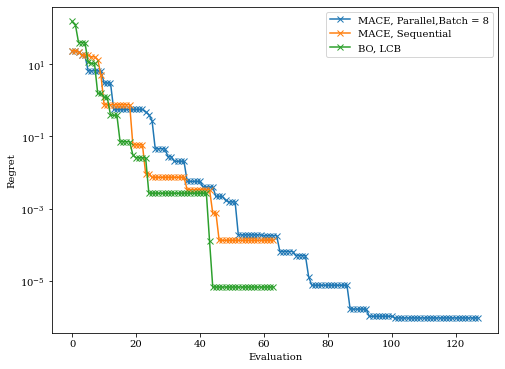

In [14]:
plt.figure(figsize = (8,6))
plt.semilogy(conv_mace_batch - problem.ideal_point(), 'x-',label = 'MACE, Parallel,Batch = 8')
plt.semilogy(conv_mace_seq   - problem.ideal_point(), 'x-',label = 'MACE, Sequential')
plt.semilogy(conv_bo_seq     - problem.ideal_point(), 'x-',label = 'BO, LCB')

plt.xlabel('Evaluation')
plt.ylabel('Regret')
plt.legend()

Batched MACE used most function evaluations because it recommend eight points per iterations, we can also plot the converge against **iterations** instead of **evaluations**

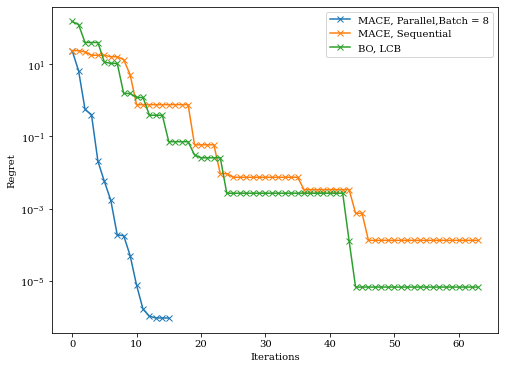

In [22]:
plt.figure(figsize = (8,6))
plt.semilogy(conv_mace_batch[::8] - problem.ideal_point(), 'x-',label = 'MACE, Parallel,Batch = 8')
plt.semilogy(conv_mace_seq   - problem.ideal_point(), 'x-',label = 'MACE, Sequential')
plt.semilogy(conv_bo_seq     - problem.ideal_point(), 'x-',label = 'BO, LCB')

plt.xlabel('Iterations')
plt.ylabel('Regret')
plt.legend()

We can see that parallel MACE converges much faster